# Training and Evaluating Classifier Model

## Turn on GPU Acceleration

Remember to turn on GPU Acceleration for this notebook. You can do so by clicking on **Runtime**, **Change Runtime Type**, selecting **GPU** for **Hardware Acceleration** and then clicking **Save**.

## Install necessary libraries

The value returned from `torch.__version__` is required to download compatible versions of `torch-scatter` and `torch-sparse`, both of which are required by Pytorch Geometric (PyG).

In [1]:
import torch
torch.__version__

'1.9.0+cu111'

In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.9.0+cu111.html

!pip install -q torch-geometric

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch_geometric.nn as pyg_nn

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import RandomNodeSplit

%matplotlib inline

## Local Imports

Since we have already developed part of this training pipeline in earlier milestones, we have packaged them as Python code which we can import in this notebook.

These Python scripts are provided to you along with the data files. You should have already uploaded the data and code to a named folder in your Google Drive in previous milestones. 

In this milestone, you will upload one additional Python file `code_p3_m2.py` containing the code for the model that we built in milestone 2.

In the code that follows, I have used `manning-data` as my folder name. If yours is different please change the name accordingly.



In [4]:
from google.colab import drive
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
!cp /content/drive/MyDrive/manning-data/code_p3_*.py .
!ls -l

total 20
-rw------- 1 root root 2594 Oct 24 20:14 code_p3_m1.py
-rw------- 1 root root 1348 Oct 24 20:14 code_p3_m2.py
drwx------ 5 root root 4096 Oct 24 19:16 drive
drwxr-xr-x 2 root root 4096 Oct 24 19:58 __pycache__
drwxr-xr-x 1 root root 4096 Oct  8 13:45 sample_data


## Set device to GPU if GPU acceleration available

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Create DataLoaders

In [7]:
import code_p3_m1

dataset, num_classes = code_p3_m1.build_dataset("/content/drive/MyDrive/manning-data")

print("dataset:", dataset)
print("num_classes:", num_classes)

dataset: Data(x=[50426, 300], edge_index=[2, 51622], y=[50426])
num_classes: 6


In [8]:
train_loader, val_loader, test_loader = code_p3_m1.get_dataloaders(dataset, batch_size=32)

print("train:", train_loader)
print("val:", val_loader)
print("test:", test_loader)

train: <torch_geometric.loader.dataloader.DataLoader object at 0x7f181b038cd0>
val: <torch_geometric.loader.dataloader.DataLoader object at 0x7f1843809710>
test: <torch_geometric.loader.dataloader.DataLoader object at 0x7f181b038990>


## Create Model

In [9]:
import code_p3_m2

input_dim = 300
hidden_dim = 100
dropout_prob = 0.2
num_gnn_layers = 3
num_classes = 6

clf_model = code_p3_m2.GNNClassifier(input_dim, hidden_dim, num_classes, num_gnn_layers, dropout_prob)
clf_model = clf_model.to(device)

## Declare Optimizer

There are a variety of different optimizers available in the [torch.optim](https://pytorch.org/docs/stable/optim.html) package. We will use the ADAM optimizer, a good general purpose optimizer suited for classification tasks.

We will set the learning rate of the optimizer to `5e-5`. We could set additional parameters, as well as the learning rate schedule at this point, but we will keep things simple and just set the learning rate.

In [10]:
LEARNING_RATE = 5e-3

optimizer = None
optimizer = optim.Adam(clf_model.parameters(), lr=LEARNING_RATE)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.005
    weight_decay: 0
)

## Training Loop

During training, our model will see the training data multiple number of times. Each of these cycles where the model goes through the entire training dataset is called an epoch. Within each epoch, we will first train the model with batches of training data, then validation the partially trained model with batches of validation data. Our training loop will look something like this:

```
for epoch in epochs:
    train_step()
    eval_stop()
```

### Train Step

The train step will run through one epoch of training data delivered in fixed size batches by the train DataLoader. Within each batch, the model should do a forward pass over the data resulting in an inference. It should then compute the loss using `model.loss()`, compute the gradients using `loss.backward()` and update the model weights using `optimizer.step()`.

Few important things to keep in mind.

1. The model needs to be set to training mode using `model.train()`. This is because some layers such as Dropout behave differently during training and inference.
2. The `RandomNodeSplit` data splitter creates mask arrays indicating which nodes fall into training, validation and test respectively, through the `train_mask`, `validation_mask` and `test_mask` respectively. These should be applied to the results in the forward pass to ensure that we calculate loss using only the training nodes.
3. The gradients of the weights need to be initialized using an `optimizer.zero_grad()` before each `loss.backward()` call.

Input parameters for the `train_step` function are the model to train, the optimizer to use for the training and the DataLoader to use for feeding the model with batches of training data. The outputs are the per node loss and accuracy of the model against the training data during the current training step.

In [11]:
def train_step(model, optimizer, train_loader):
  ## - set the model to train
  model.train()
  total_rows, total_loss, total_correct = 0, 0, 0
  for batch in train_loader:
    ## (1) copy the batch object to the device
    ## (2) initialize the optimizer gradients
    ## (3) generate predictions for training set using currently trained model
    ## (4) compute loss between label and predictions (use model.loss())
    ## (5) compute the gradient of the loss (loss.backward())
    ## (6) update the model parameter (optimizer.step())
    batch = batch.to(device)
    optimizer.zero_grad()
    pred = model(batch)[batch.train_mask]
    label = batch.y[batch.train_mask]
    loss = model.loss(pred, label)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_correct += pred.max(dim=1)[1].eq(label).sum().item()
    total_rows += torch.sum(batch.train_mask).item()
  return total_loss / total_rows, total_correct / total_rows

### Evaluation Step

We use the evaluation step to test our partially trained model against data from our validation split.

This is similar to the `train_step` function except that we are doing inference here, thus there is no code to backpropagate the gradient of the loss to the model weights.

Important things to keep in mind here.

1. Set the model to eval mode using `model.eval()`.
2. Use the appropriate mask to select predictions for only the validation subset of the nodes.
3. You still need to compute the loss, just not back-propagate it.

Because the functionality of the evaluation step can be re-used when evaluating the fully trained model on our held-out test split, the input parameters to this function will include the DataLoader (validation or test) to use, and a flag indicating if this is for validation, in addition to the model. Outputs are the per node loss and validation accuracy of the model.

In [12]:
def eval_step(model, test_loader, is_validation=False):
  ## - set the model to eval mode
  model.eval()
  total_rows, total_loss, total_correct = 0, 0, 0
  for batch in test_loader:
    ## (1) copy batch object to device
    ## (2) select val_mask if is_validation True else test_mask
    ## (3) compute predictions using appropriate split (validation or test)
    ##.(4) compute loss
    batch = batch.to(device)
    mask = batch.val_mask if is_validation else batch.test_mask
    with torch.no_grad():
      pred = model(batch)[mask]
      label = batch.y[mask]
    loss = model.loss(pred, label)
    total_loss += loss.item()
    total_correct += pred.max(dim=1)[1].eq(label).sum().item()
    total_rows += torch.sum(mask).item()
  return total_loss / total_rows, total_correct / total_rows

### Train Model

The training loop is just the `train_step` and `eval_step` called alternately at each epoch of training. Since both functions return the loss and accuracy, we print these at the end of each epoch, and save them off into the `history` list object for viauslization.


We also check whether GPU acceleration is available and if so, move the model to the GPU. Recall that we have already moved our data batches to the device given by the current device.


In [13]:
NUM_EPOCHS = 200

history = []
for epoch in range(NUM_EPOCHS):
  train_loss, train_acc, val_loss, val_acc = None, None, None, None
  ## (1) call train_step with model, optimizer and train_loader, return
  ##     train_loss and train_acc
  ## (2) call eval_step with model, val_loader and is_validation=True, 
  ##     return val_loss and val_acc
  train_loss, train_acc = train_step(clf_model, optimizer, train_loader)
  val_loss, val_acc = eval_step(clf_model, val_loader, is_validation=True)
  history.append((train_loss, train_acc, val_loss, val_acc))
  if (epoch + 1) % 10 == 0:
    print("EPOCH {:3d}, TRAIN loss: {:.5f}, acc: {:.5f}, VAL loss: {:.5f}, acc: {:.5f}"
      .format(epoch + 1, train_loss, train_acc, val_loss, val_acc))

EPOCH  10, TRAIN loss: 0.00004, acc: 0.43090, VAL loss: 0.00028, acc: 0.44775
EPOCH  20, TRAIN loss: 0.00004, acc: 0.47005, VAL loss: 0.00026, acc: 0.51735
EPOCH  30, TRAIN loss: 0.00004, acc: 0.52612, VAL loss: 0.00024, acc: 0.55126
EPOCH  40, TRAIN loss: 0.00003, acc: 0.54621, VAL loss: 0.00023, acc: 0.56415
EPOCH  50, TRAIN loss: 0.00003, acc: 0.57700, VAL loss: 0.00022, acc: 0.58596
EPOCH  60, TRAIN loss: 0.00003, acc: 0.61596, VAL loss: 0.00021, acc: 0.62304
EPOCH  70, TRAIN loss: 0.00003, acc: 0.62686, VAL loss: 0.00020, acc: 0.63514
EPOCH  80, TRAIN loss: 0.00003, acc: 0.63536, VAL loss: 0.00019, acc: 0.64684
EPOCH  90, TRAIN loss: 0.00003, acc: 0.64511, VAL loss: 0.00019, acc: 0.65080
EPOCH 100, TRAIN loss: 0.00003, acc: 0.65015, VAL loss: 0.00019, acc: 0.64485
EPOCH 110, TRAIN loss: 0.00003, acc: 0.65324, VAL loss: 0.00019, acc: 0.65517
EPOCH 120, TRAIN loss: 0.00003, acc: 0.66463, VAL loss: 0.00019, acc: 0.65695
EPOCH 130, TRAIN loss: 0.00003, acc: 0.67154, VAL loss: 0.00018,

### Plot training loss and accuracy

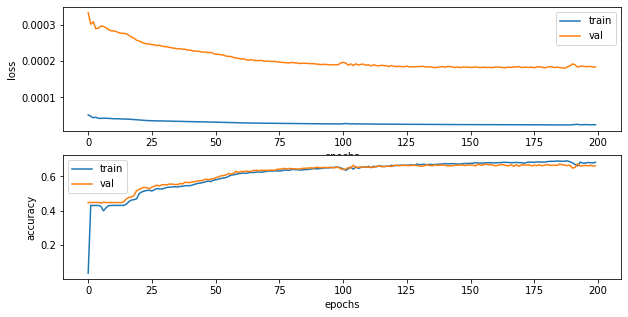

In [14]:
train_losses, train_accs, val_losses, val_accs = [], [], [], []
for train_loss, train_acc, val_loss, val_acc in history:
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  train_accs.append(train_acc)
  val_accs.append(val_acc)

epochs = np.arange(len(history))

plt.figure(figsize=(10, 5))

plt.subplot(2, 1, 1)
plt.plot(epochs, train_losses, label="train")
plt.plot(epochs, val_losses, label="val")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc="best")

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accs, label="train")
plt.plot(epochs, val_accs, label="val")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(loc="best")

_ = plt.show()

## Evaluate Trained Model

Finally, we want to see how effective our model is against the held-out test data. 

The evaluation against the test data is the same as running the test data against the model and calculating the accuracy over all the batches. This is essentially what we built for the `eval_step`, except it was using validation data and a partially trained model. So we can basically re-use the `eval_step` function to evaluate our trained model as shown below.

In [15]:
test_acc = None
## - call eval_step with model test_loader, and is_validation=False
##   capture test_acc
_, test_acc = eval_step(clf_model, test_loader)
print("test accuracy:", test_acc)

test accuracy: 0.6606841844323252
